# Project 2: House Prices Predictions

## Problem Statement

- Getting a dream house with a true price is not easy. There is always a real estate agent or a house owner pushing the price up too high. This model, hopefully can help people estimate a real house price before purchasing it. 

### Contents

- [Data Cleaning](#Data-Cleaning)
    + [Remove Unnecessary Columns and Edit Column Names](#Remove-Unnecessary-Columns-and-Edit-Column-Names)
    + [Handle Skewness and Linearity Assumption](#Handle-Skewness-and-Linearity-Assumption)
    + [Handle Multicollinearity](#Handle-Multicollinearity)
    + [Data Imputation](#Data-Imputation)
- [Modeling](#Modeling)
    + [Linear Regression](#Linear-Regression)
    + [Ridge Regression](#Ridge-Regression)
    + [Lasso Regression](#Lasso-Regression)
    + [Elastic Net Regression](#Elastic-Net-Regression)
- [Predicting Testing File](#Predicting-Testing-File)    

In [1]:
# Importing library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNet, ElasticNetCV
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

### Remove Unnecessary Columns and Edit Column Names

In [2]:
data = pd.read_csv("datasets/train.csv",na_values = "", keep_default_na = False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              2051 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         2

In [4]:
data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [5]:
data.shape

(2051, 81)

In [6]:
data.columns = data.columns.str.replace(" ", "_")

- We will drop **Id** and **PID** column as it is irrelevant in our analysis

In [7]:
data.drop(columns = ["Id", "PID"], inplace = True)

In [8]:
data.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,SalePrice
0,60,RL,NaN,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,60,RL,43.0,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,20,RL,68.0,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,60,RL,73.0,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,50,RL,82.0,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,3,2010,WD,138500


### Handle Skewness and Linearity Assumption

In [9]:
X = data.loc[:,data.columns != "SalePrice"]
y = data["SalePrice"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [10]:
category_columns = {i : X_train[i].unique() 
                    for i in X_train.columns 
                    if len(X_train[i].unique()) < 30 
                    or "Year" in i or "Yr" in i 
                   }
category_columns

{'MS_SubClass': array([ 20,  70,  60,  50,  80, 160,  75,  30, 120, 190,  90,  85,  45,
         40, 180, 150], dtype=int64),
 'MS_Zoning': array(['RL', 'RM', 'FV', 'RH', 'C (all)', 'A (agr)'], dtype=object),
 'Street': array(['Pave', 'Grvl'], dtype=object),
 'Alley': array(['NA', 'Grvl', 'Pave'], dtype=object),
 'Lot_Shape': array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object),
 'Land_Contour': array(['Lvl', 'Bnk', 'HLS', 'Low'], dtype=object),
 'Utilities': array(['AllPub'], dtype=object),
 'Lot_Config': array(['Inside', 'CulDSac', 'Corner', 'FR2', 'FR3'], dtype=object),
 'Land_Slope': array(['Gtl', 'Mod', 'Sev'], dtype=object),
 'Neighborhood': array(['NAmes', 'Sawyer', 'ClearCr', 'NoRidge', 'SWISU', 'OldTown',
        'CollgCr', 'Edwards', 'Somerst', 'NWAmes', 'Mitchel', 'NridgHt',
        'Timber', 'Gilbert', 'BrkSide', 'IDOTRR', 'Crawfor', 'StoneBr',
        'SawyerW', 'Blueste', 'MeadowV', 'Blmngtn', 'NPkVill', 'GrnHill',
        'BrDale', 'Landmrk', 'Veenker', 'Greens'], dtype=obj

In [11]:
# Filter 1 more time the category columns
category_columns = [i for i in category_columns.keys() 
                    if i not in ['Low_Qual_Fin_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 
                                 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd', 'Fireplaces', 'Pool_Area', 
                                 'Garage_Cars', '3Ssn_Porch', 'Misc_Val']
                   ]

In [12]:
numerical_columns = [i for i in X_train.columns if i not in category_columns]
numerical_columns

['Lot_Frontage',
 'Lot_Area',
 'Mas_Vnr_Area',
 'BsmtFin_SF_1',
 'BsmtFin_SF_2',
 'Bsmt_Unf_SF',
 'Total_Bsmt_SF',
 '1st_Flr_SF',
 '2nd_Flr_SF',
 'Low_Qual_Fin_SF',
 'Gr_Liv_Area',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Full_Bath',
 'Half_Bath',
 'Bedroom_AbvGr',
 'Kitchen_AbvGr',
 'TotRms_AbvGrd',
 'Fireplaces',
 'Garage_Cars',
 'Garage_Area',
 'Wood_Deck_SF',
 'Open_Porch_SF',
 'Enclosed_Porch',
 '3Ssn_Porch',
 'Screen_Porch',
 'Pool_Area',
 'Misc_Val']

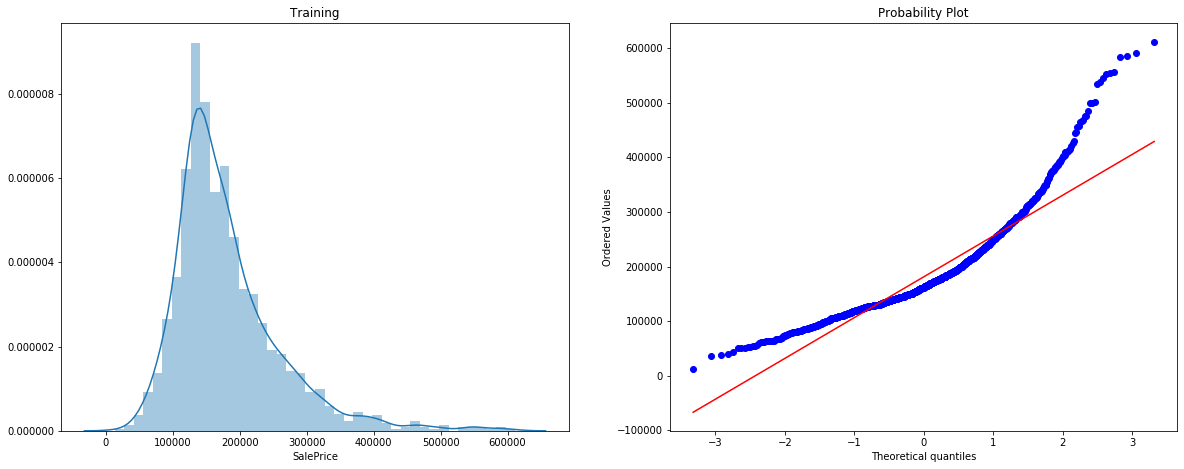

In [13]:
fig, ax = plt.subplots(nrows= 1, ncols= 2,figsize = (20, 7.5))
sns.distplot(y_train, ax = ax[0]).set_title("Training")
probplot = sc.probplot(y_train, plot = plt)

- Since the SalePrice on training datset is right skewed, we are going to peform log on it to make it more normally distributed. 

In [14]:
y_train = np.log(y_train)
y_test = np.log(y_test)

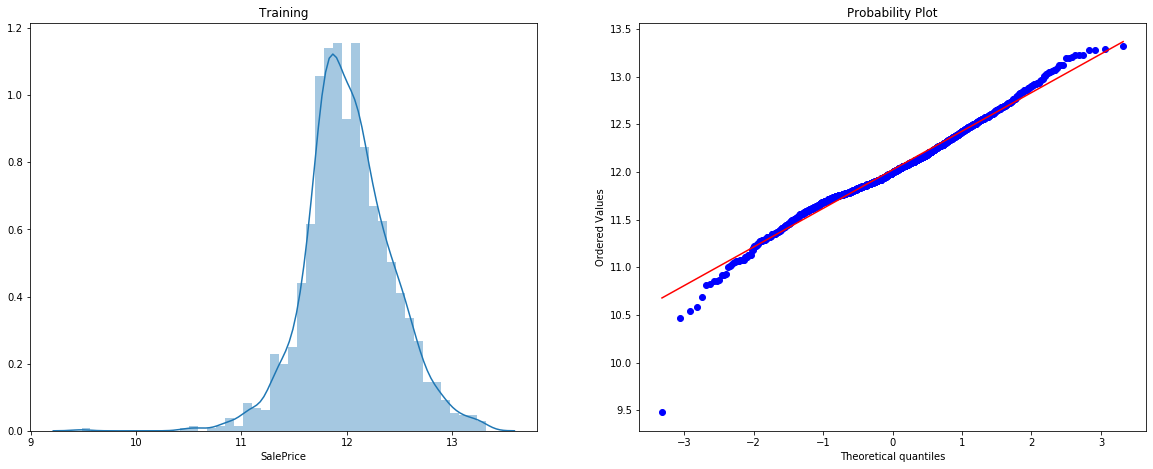

In [15]:
fig, ax = plt.subplots(nrows= 1, ncols= 2,figsize = (20, 7.5))
sns.distplot(y_train, ax=ax[0]).set_title("Training")
probplot = sc.probplot(y_train, plot = plt)

- The SalePrice for our training dataset is now more normally distributed

- Let's make a histogram plot for all numerical columns detect which features have extreme outliers

In [16]:
# Plot histograms for columns that we want

# Input:
# dataframe: a DataFrame
# list_of_columns : columns of the dataframe that we want to plot - list of string
# list_of_titles : titles of columns that we want to plot - list of string

def subplot_histograms(dataframe, list_of_columns, list_of_titles, figsize = (20,5), ncol = 4):
    nrows = int(np.ceil(len(list_of_columns)/ncol)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=ncol,figsize = figsize)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column]) 
        ax[i].set_title(list_of_titles[i])

<Figure size 432x288 with 0 Axes>

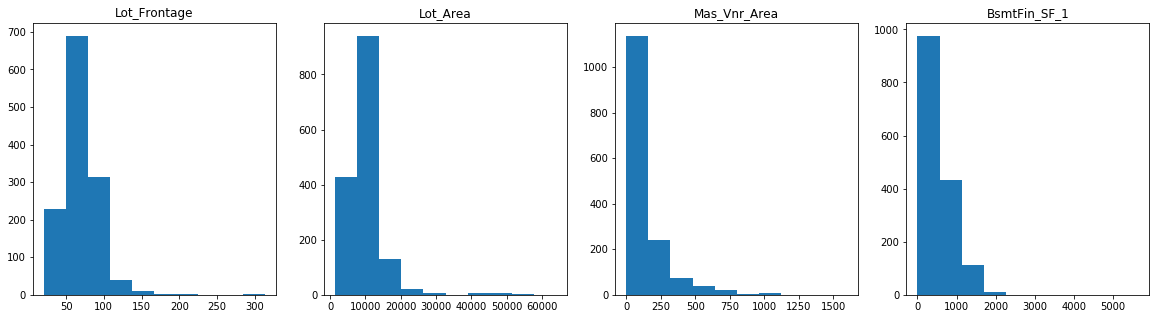

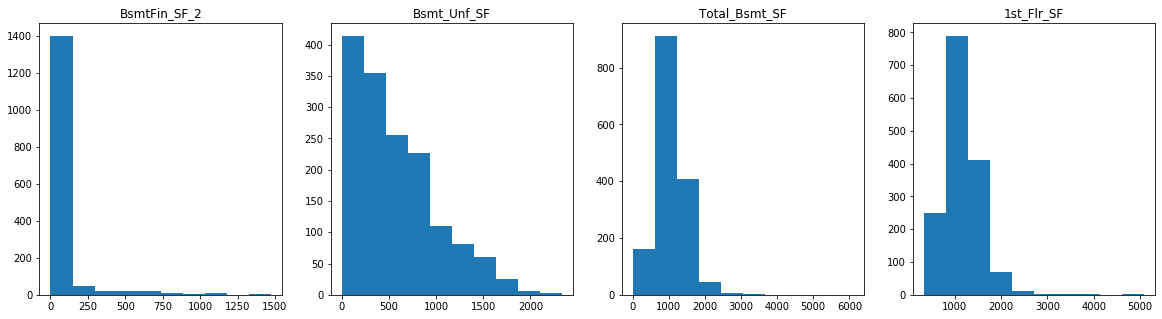

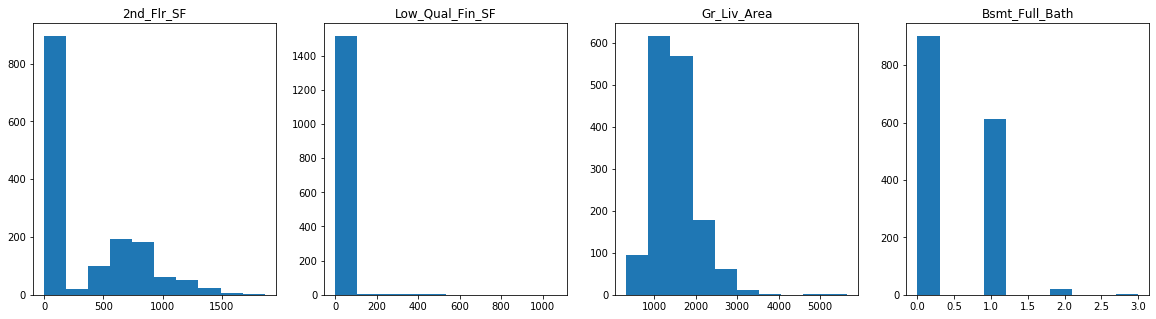

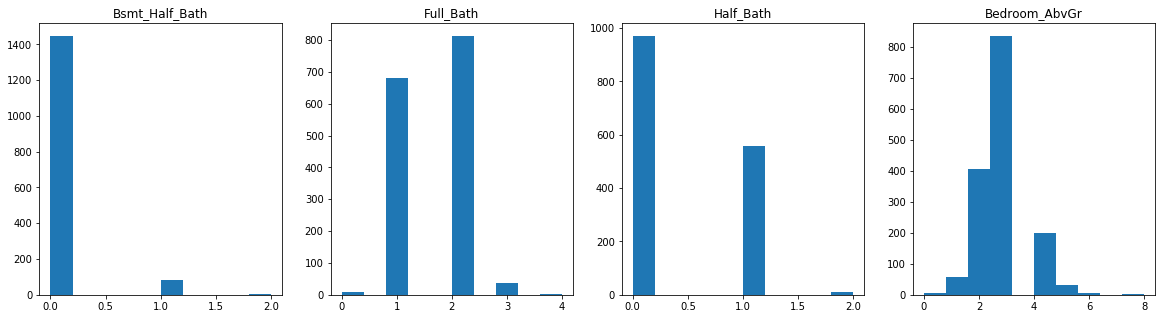

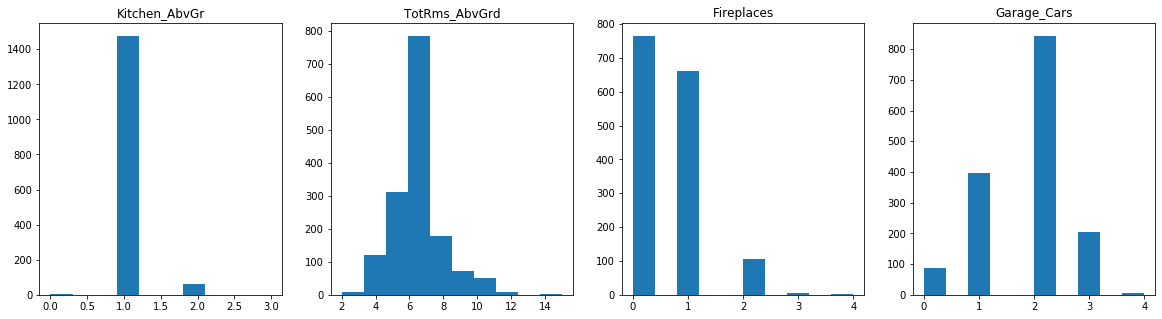

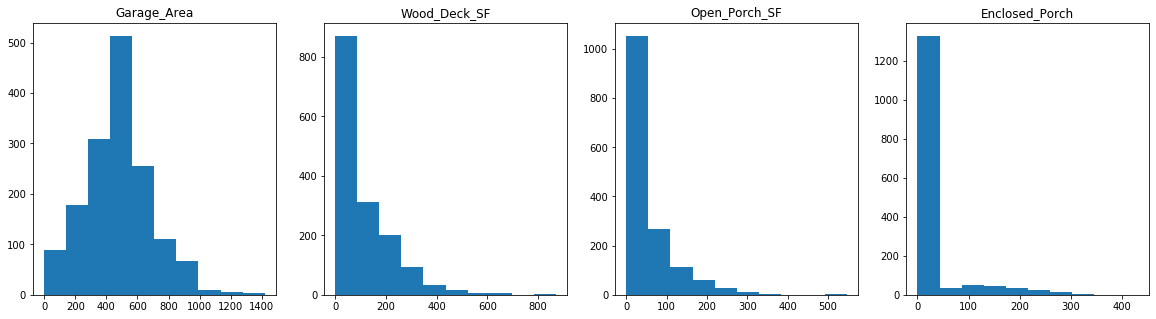

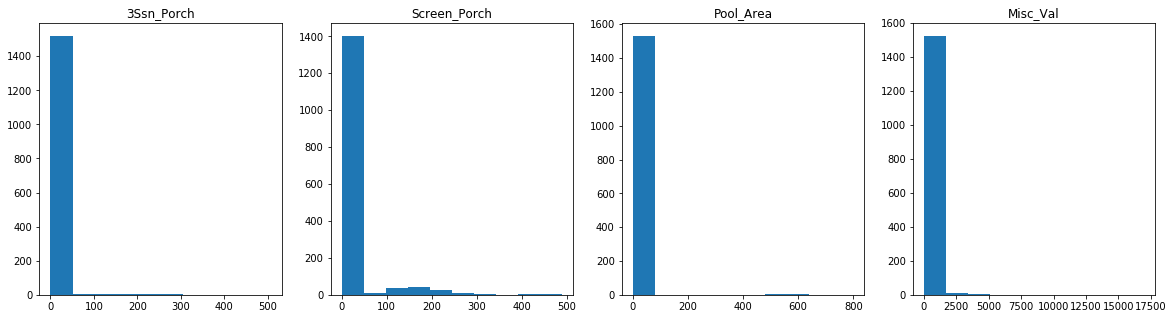

<Figure size 1440x360 with 0 Axes>

In [17]:
plt.figure()
for i in range(0,32,4):
        subplot_histograms(X_train,numerical_columns[i:i+4],numerical_columns[i:i+4])

- Almost all of our numerical features are heavily right skewed. We need to remove some of the outlier to make the data become more normally distributed

- I will try to be as conservative as possible to prevent removing too much data
- For all of the columns shown above most of the values is 0. Removing the outlier in these columns will not help improve the model

In [18]:
# We are not going to remove columns with too much 0
# Find columns with mostly 0

many_zero_col =[i for i in numerical_columns if X_train.describe().loc["50%",i] == 0 or X_train.describe().loc["75%",i] == 0]
many_zero_col

['Mas_Vnr_Area',
 'BsmtFin_SF_2',
 '2nd_Flr_SF',
 'Low_Qual_Fin_SF',
 'Bsmt_Full_Bath',
 'Bsmt_Half_Bath',
 'Half_Bath',
 'Wood_Deck_SF',
 'Enclosed_Porch',
 '3Ssn_Porch',
 'Screen_Porch',
 'Pool_Area',
 'Misc_Val']

In [19]:
# Find the remaining columns

remaining_col = list(set(numerical_columns) - set(many_zero_col))
remaining_col

['Garage_Area',
 'TotRms_AbvGrd',
 'Full_Bath',
 'Open_Porch_SF',
 '1st_Flr_SF',
 'Lot_Area',
 'BsmtFin_SF_1',
 'Fireplaces',
 'Bedroom_AbvGr',
 'Total_Bsmt_SF',
 'Kitchen_AbvGr',
 'Garage_Cars',
 'Lot_Frontage',
 'Gr_Liv_Area',
 'Bsmt_Unf_SF']

In [20]:
iqr = sc.iqr(X_train[remaining_col], axis = 0, nan_policy = "omit" )

In [21]:
q25, q75 = np.nanpercentile(X_train[remaining_col], axis = 0, q = [25,75])

In [22]:
# Normally people will use 1.5, but I will use 3 to be more conservative
min_val = q25 - 3*iqr
max_val = q75 + 3*iqr

In [23]:
outlier_row = [X_train[(X_train[col] < min_val[i]) | (X_train[col] > max_val[i])].index for i, col in enumerate(remaining_col)]

In [24]:
outlier_row = set([j for i in outlier_row for j in i])

In [25]:
# dropping these rows from our training datasets
X_train.drop(set(outlier_row), inplace = True)
y_train.drop(set(outlier_row), inplace = True)

<Figure size 432x288 with 0 Axes>

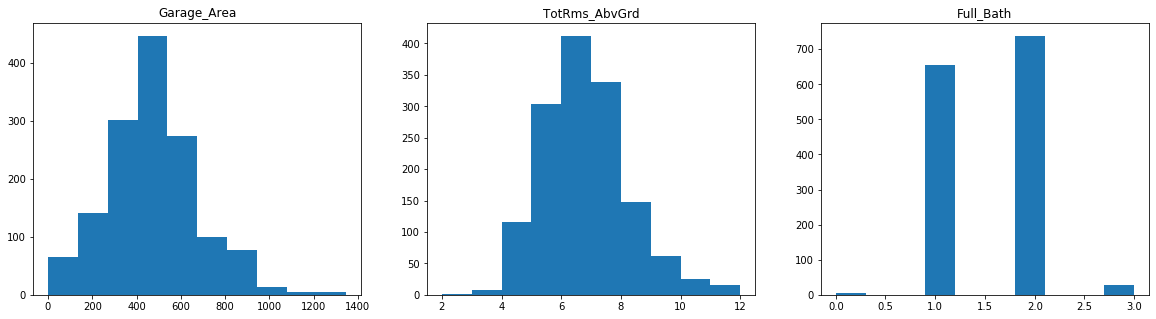

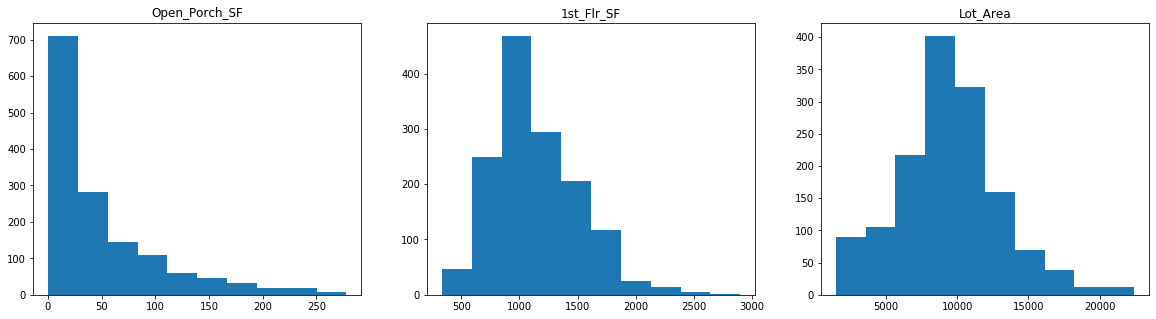

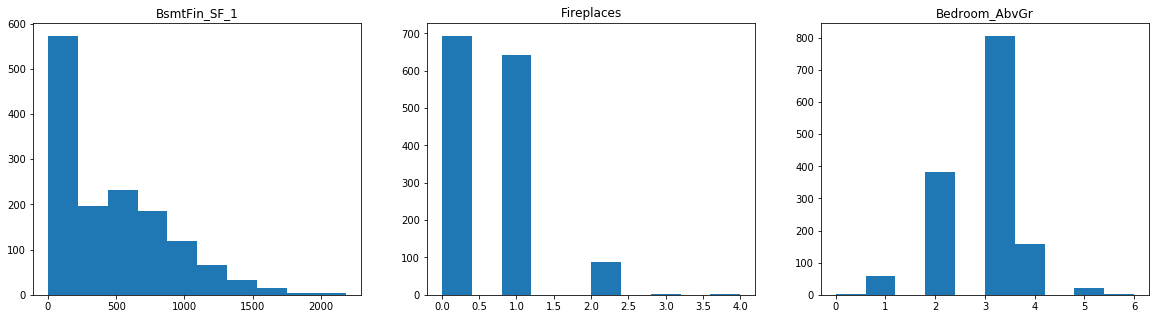

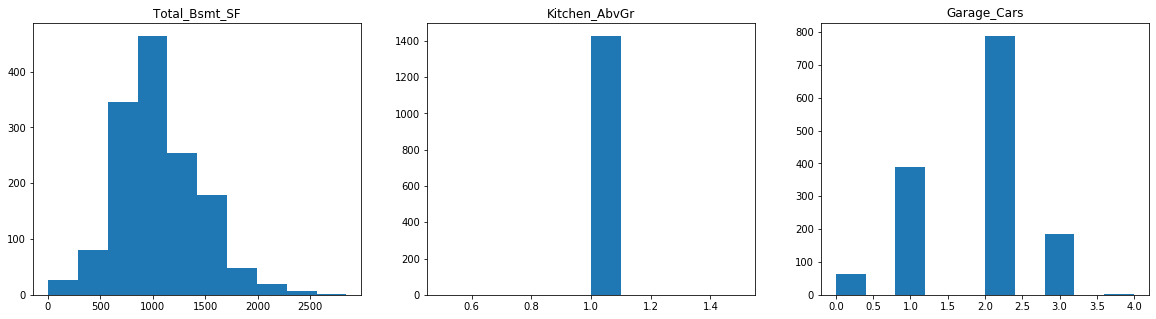

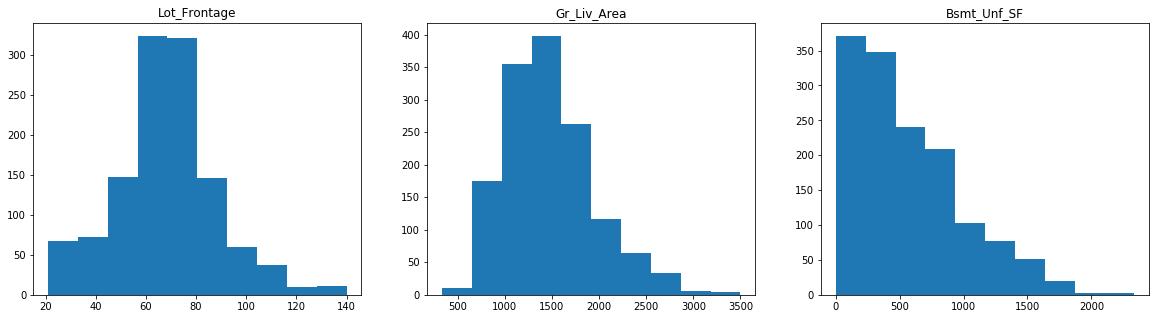

<Figure size 1440x360 with 0 Axes>

In [26]:
plt.figure()
for i in range(0,18,3):
        subplot_histograms(X_train,remaining_col[i:i+3],remaining_col[i:i+3],ncol = 3, figsize = (20,5))

- Our data is getting much better now, more columns become more normal distributed
- We still need to check the skewness value of each numerical columns to make sure everything is ok. If the skewness is high for any columns, we are going to apply boxcox transformation on them

In [27]:
{i : sc.skew(X_train[i], nan_policy = "omit") for i in numerical_columns }

{'Lot_Frontage': masked_array(data=0.17078855,
              mask=False,
        fill_value=1e+20),
 'Lot_Area': 0.3222101545218486,
 'Mas_Vnr_Area': masked_array(data=2.60212476,
              mask=False,
        fill_value=1e+20),
 'BsmtFin_SF_1': masked_array(data=0.81541118,
              mask=False,
        fill_value=1e+20),
 'BsmtFin_SF_2': masked_array(data=4.37087523,
              mask=False,
        fill_value=1e+20),
 'Bsmt_Unf_SF': masked_array(data=0.89954917,
              mask=False,
        fill_value=1e+20),
 'Total_Bsmt_SF': masked_array(data=0.48595402,
              mask=False,
        fill_value=1e+20),
 '1st_Flr_SF': 0.8131439561031567,
 '2nd_Flr_SF': 0.8422341877387258,
 'Low_Qual_Fin_SF': 12.715280089871701,
 'Gr_Liv_Area': 0.8549106167411875,
 'Bsmt_Full_Bath': masked_array(data=0.56747412,
              mask=False,
        fill_value=1e+20),
 'Bsmt_Half_Bath': masked_array(data=4.01162722,
              mask=False,
        fill_value=1e+20),
 'Full_Bath': 0.1

In [28]:
[i for i in numerical_columns if sc.skew(X_train[i], nan_policy = "omit") > 7]

['Low_Qual_Fin_SF', '3Ssn_Porch', 'Pool_Area', 'Misc_Val']

In [29]:
# Apply Box Cox transformation for all the comlumns shown above
from scipy.special import boxcox1p
for i in ['3Ssn_Porch', 'Low_Qual_Fin_SF', 'Misc_Val', 'Pool_Area']:
    X_train[i] = boxcox1p(X_train[i], 0.15)

for i in ['3Ssn_Porch', 'Low_Qual_Fin_SF', 'Misc_Val', 'Pool_Area']:
    X_test[i] = boxcox1p(X_test[i], 0.15)

In [30]:
{i : sc.skew(X_train[i], nan_policy = "omit") for i in numerical_columns }

{'Lot_Frontage': masked_array(data=0.17078855,
              mask=False,
        fill_value=1e+20),
 'Lot_Area': 0.3222101545218486,
 'Mas_Vnr_Area': masked_array(data=2.60212476,
              mask=False,
        fill_value=1e+20),
 'BsmtFin_SF_1': masked_array(data=0.81541118,
              mask=False,
        fill_value=1e+20),
 'BsmtFin_SF_2': masked_array(data=4.37087523,
              mask=False,
        fill_value=1e+20),
 'Bsmt_Unf_SF': masked_array(data=0.89954917,
              mask=False,
        fill_value=1e+20),
 'Total_Bsmt_SF': masked_array(data=0.48595402,
              mask=False,
        fill_value=1e+20),
 '1st_Flr_SF': 0.8131439561031567,
 '2nd_Flr_SF': 0.8422341877387258,
 'Low_Qual_Fin_SF': 8.159946473150226,
 'Gr_Liv_Area': 0.8549106167411875,
 'Bsmt_Full_Bath': masked_array(data=0.56747412,
              mask=False,
        fill_value=1e+20),
 'Bsmt_Half_Bath': masked_array(data=4.01162722,
              mask=False,
        fill_value=1e+20),
 'Full_Bath': 0.11

- The skewness improves for all the columns. Pool Area still have a high skewness scores. Most likely, it dues to too many zeros in the columns

In [31]:
# Plot scatters plot for columns that we want

# Input:
# dataframe: a DataFrame
# list_of_columns : columns of the dataframe that we want to plot - list of string
# list_of_titles : titles of columns that we want to plot - list of string

def subplot_scatter(dataframe, list_of_columns, list_of_titles, figsize = (20,5), ncol = 4):
    nrows = int(np.ceil(len(list_of_columns)/ncol)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=ncol,figsize = figsize)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].scatter(dataframe[column],y_train) 
        ax[i].set_title(list_of_titles[i])

<Figure size 432x288 with 0 Axes>

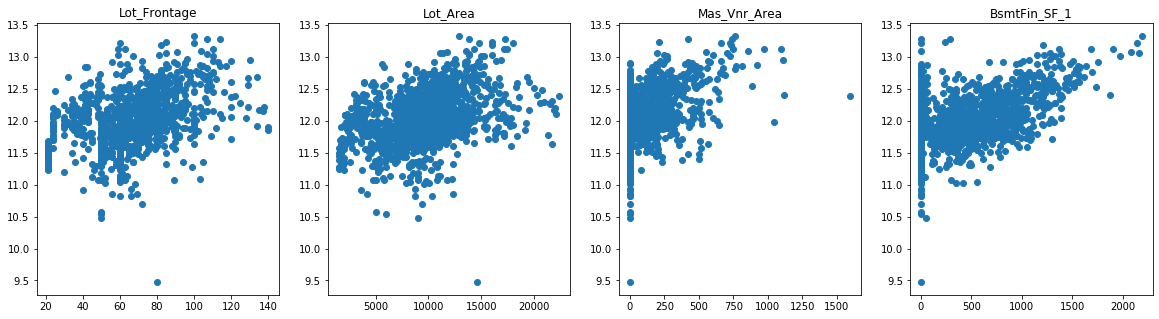

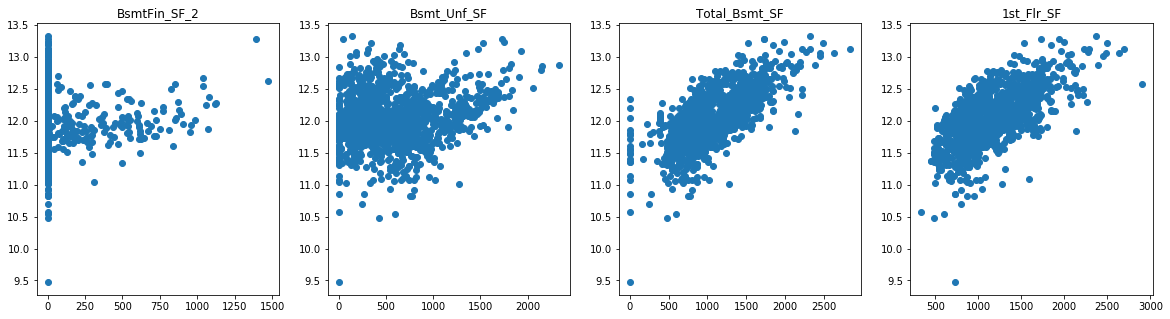

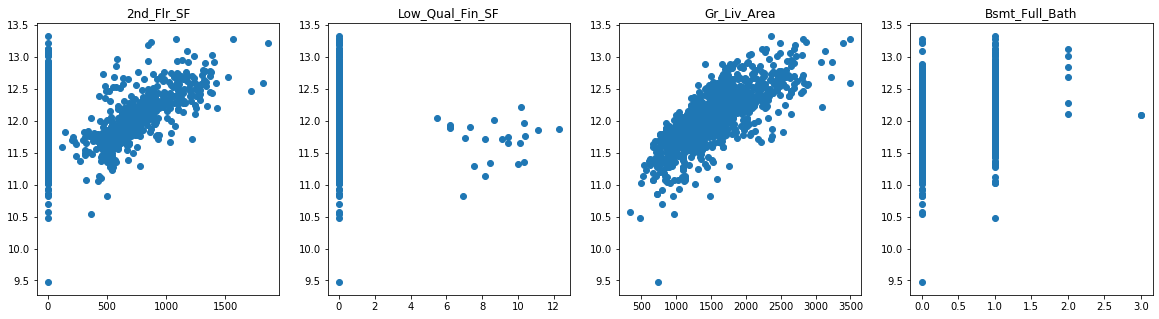

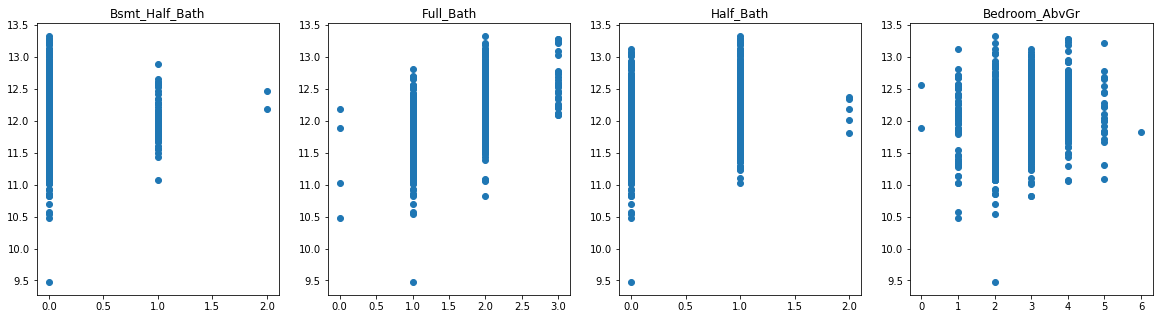

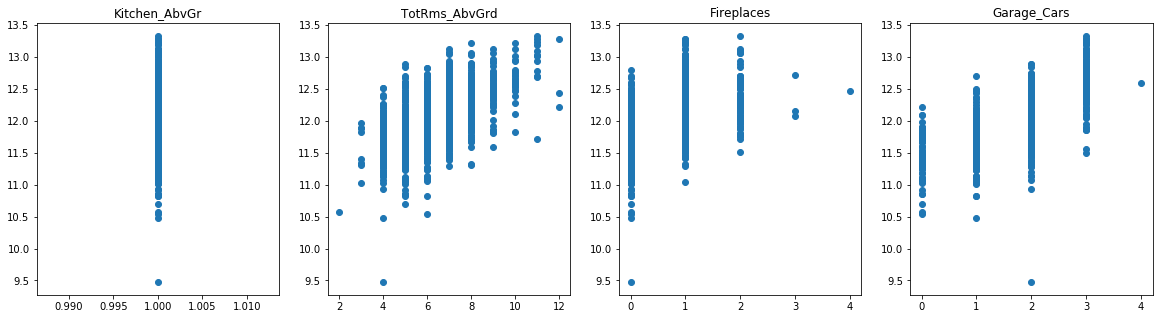

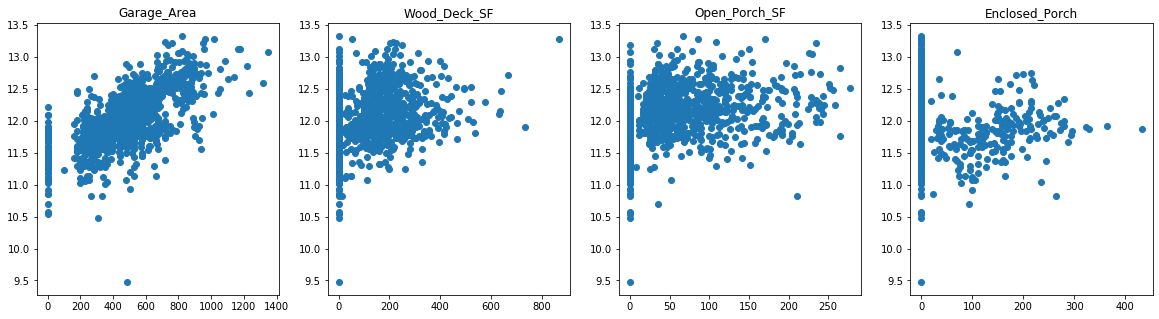

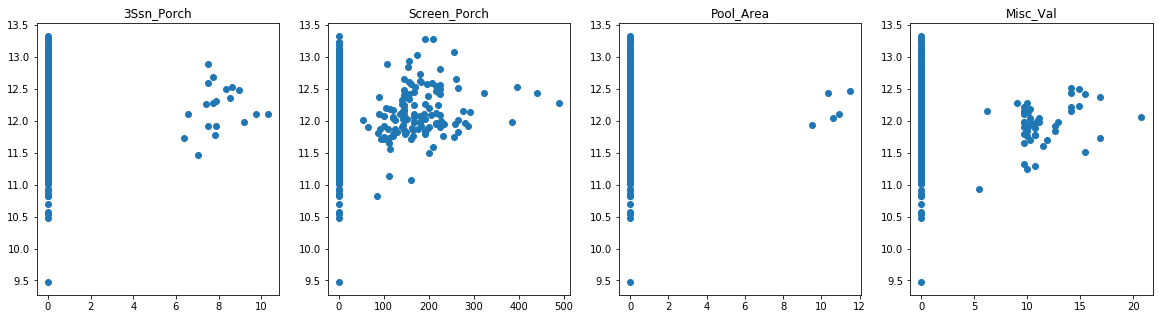

<Figure size 1440x360 with 0 Axes>

In [32]:
plt.figure()
for i in range(0,32,4):
        subplot_scatter(X_train,numerical_columns[i:i+4],numerical_columns[i:i+4])

- Most of the numerical independent variables is linearly related to dependent variable

### Handle Multicollinearity

- We are going to check which features are highly correlated with each other using the threshold of 0.8. If the correlation between those features is greater than 0.8, we will remove either one of them

In [33]:
correlation = X_train.corr()

In [34]:
set([" and ".join(sorted([col, ind])) 
     for col in correlation.columns 
     for ind in correlation.index 
     if abs(correlation.loc[ind,col]) > 0.8 and col != ind])

{'1st_Flr_SF and Total_Bsmt_SF',
 'Garage_Area and Garage_Cars',
 'Garage_Yr_Blt and Year_Built',
 'Gr_Liv_Area and TotRms_AbvGrd'}

- After checking, we can see that the following features are highly correlated:
    - 1st Flr SF and Total Bsmt SF
    - Garage Area and Garage Cars
    - Garage Yr Blt and Year Built
    - Gr Liv Area and TotRms AbvGrd

- Total_Bsmt_SF, Garage_Cars, Year_Built and TotRms_AbvGrd columns will be removed

In [35]:
X_train.drop(columns= ["Total_Bsmt_SF", "Garage_Cars", "Year_Built", "TotRms_AbvGrd"], inplace = True)
X_test.drop(columns= ["Total_Bsmt_SF", "Garage_Cars", "Year_Built", "TotRms_AbvGrd"], inplace = True)

### Data Imputation

In [36]:
# Updated category columns
category_columns = {i : X_train[i].unique() 
                    for i in X_train.columns 
                    if len(X_train[i].unique()) < 30 or "Year" in i or "Yr" in i}
category_columns = [i for i in category_columns.keys() 
                    if i not in ['Low_Qual_Fin_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 
                                 'Bedroom_AbvGr', 'Kitchen_AbvGr', 'TotRms_AbvGrd', 'Fireplaces', 'Pool_Area', 
                                 'Garage_Cars', '3Ssn_Porch', 'Misc_Val']]

In [37]:
# Updated numerical columns
numerical_columns = [i for i in X_train.columns if i not in category_columns]

In [38]:
# Perform mean imputation, and standard scaler for numerical columns
clean_numerical = [([i],[SimpleImputer(), StandardScaler()]) for i in numerical_columns]

In [39]:
# Perform most frequent imputation, and LabelBinarizer for category columns
clean_nominal = [([i],[SimpleImputer(strategy = "most_frequent"), MultiLabelBinarizer()]) for i in category_columns]

## Modeling

In [40]:
mapper = DataFrameMapper(clean_numerical + clean_nominal, df_out = True)
X_train = mapper.fit_transform(X_train)
X_test = mapper.transform(X_test)

### Linear Regression Model

In [41]:
lm = LinearRegression()
lm.fit(X_train,y_train)
print("Linear Regression Model:")
print("Cross Validation score is:",cross_val_score(lm, X_train, y_train, cv = 10).mean())
print("Training score is:", lm.score(X_train,y_train))
print("Testing score is:", lm.score(X_test,y_test))

Linear Regression Model:
Cross Validation score is: -1.4197235979119575e+19
Training score is: 0.966237523315157
Testing score is: -2.7551736238564816e+16


- Extremely overfit. Hence we are goint to try to apply Lasso or Ridge regression on this model

### Ridge Regression Model

In [42]:
alpha = np.logspace(0.1,10,50)
ridge = RidgeCV(alphas=alpha)
ridge.fit(X_train,y_train)
alpha = ridge.alpha_

In [43]:
# Ridge regression with optimal alpha
ridge = Ridge(alpha=alpha, random_state = 42)
ridge.fit(X_train,y_train)
print("Ridge Regression Model with alpha =", alpha,":")
print("Cross Validation score is:",cross_val_score(ridge, X_train, y_train, cv = 10).mean())
print("Training score is:", ridge.score(X_train,y_train))
print("Testing score is:", ridge.score(X_test,y_test))

Ridge Regression Model with alpha = 5.083027379064073 :
Cross Validation score is: 0.9143678829588424
Training score is: 0.9559865609009027
Testing score is: 0.869285921588536


### Lasso Regression Model

In [44]:
lasso = LassoCV(n_alphas=500,cv=10)
lasso.fit(X_train,y_train)
alpha = lasso.alpha_

In [45]:
# lasso regression with optimal alpha
lasso = Lasso(alpha=alpha, random_state = 42)
lasso.fit(X_train,y_train)
print("Lasso Regression Model with alpha =", alpha,":")
print("Cross Validation score is:",cross_val_score(lasso, X_train, y_train, cv = 10).mean())
print("Training score is:", lasso.score(X_train,y_train))
print("Testing score is:", lasso.score(X_test,y_test))

Lasso Regression Model with alpha = 0.0002989834646684038 :
Cross Validation score is: 0.9140662436263742
Training score is: 0.9497256110172585
Testing score is: 0.8719907270951517


### Elastic Regression Model

In [46]:
elastic = ElasticNetCV(l1_ratio= np.linspace(0.01,0.99,100), cv = 10)
elastic.fit(X_train, y_train)
alpha = elastic.alpha_
l1_ratio = elastic.l1_ratio_

In [47]:
elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state = 42)
elastic.fit(X_train,y_train)
print("Elastic Regression Model with alpha =", alpha,"and l1 ratio =", l1_ratio, ":")
print("Cross Validation score is:",cross_val_score(elastic, X_train, y_train, cv = 10).mean())
print("Training score is:", elastic.score(X_train,y_train))
print("Testing score is:", elastic.score(X_test,y_test))

Elastic Regression Model with alpha = 0.001041131305035947 and l1 ratio = 0.2871717171717172 :
Cross Validation score is: 0.91426026773893
Training score is: 0.9475899658852652
Testing score is: 0.8705861024787154


- Lasso seems to perform better than the rest. We are goint to apply Lasso Regression to predict our testing set

## Predict Testing File

In [48]:
testing_file = pd.read_csv("datasets/test.csv",na_values = "", keep_default_na = False)
testing_file.columns = testing_file.columns.str.replace(" ", "_")

In [49]:
testing_file.head()

,Id,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In [50]:
id_col = testing_file["Id"]

In [51]:
test = testing_file[category_columns + numerical_columns]

In [52]:
test = mapper.transform(testing_file)

In [53]:
test_predict = np.exp(lasso.predict(test))

In [54]:
result = pd.DataFrame({"Id" : id_col,
                       "SalePrice" : test_predict})

In [55]:
result.to_csv("datasets/submit.csv",index = False)